You might need to install this on your system:

apt-get install python3-opencv git

In [ ]:
import os
if not os.path.isdir('k'):
 !git clone -b development15 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Cloning into 'k'...
remote: Enumerating objects: 1577, done.
remote: Counting objects: 100% (1026/1026), done.
remote: Compressing objects: 100% (673/673), done.
remote: Total 1577 (delta 744), reused 604 (delta 348), pack-reused 551
Receiving objects: 100% (1577/1577), 15.08 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.6-py3-none-any.whl size=59903 sha256=4e8a715544bf893019edae474f5475f9382ae22d007bff3fba2c3470ac23daab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ecbsm4ib/wheels/c1/8a/57/56dbba25eff58e52e53

In [ ]:
import cai.layers
import cai.datasets
import cai.models
import cai.densenet
import cai.efficientnet
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import gc
import multiprocessing
import random
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report
import shutil

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 8
RAM: 54.767017984 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sun Feb 13 11:48:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Download Files and Create Validation and Test Datasets

In [ ]:
verbose=True
root_folder = 'malaria'
train_dir = root_folder + '/cell_images'
val_dir = root_folder + '/val'
test_dir = root_folder + '/test'

url_zip_file = 'https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip'
local_zip_file = 'malaria.zip'
expected_folder_name = root_folder

if not os.path.isdir(root_folder):
  cai.datasets.download_zip_and_extract(url_zip_file, local_zip_file, expected_folder_name, verbose)
  cai.datasets.extract_subset_every(train_dir, val_dir, move_every=10, shift=0, verbose=verbose)
  cai.datasets.extract_subset_every(train_dir, test_dir, move_every=9, shift=0, verbose=verbose)

Downloading:  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip  to  malaria.zip
Decompressing into:  malaria
Creating folder malaria/val
Creating folder malaria/val/Uninfected
Creating folder malaria/val/Parasitized
1378 files have been moved from malaria/cell_images/Uninfected to malaria/val/Uninfected.
1378 files have been moved from malaria/cell_images/Parasitized to malaria/val/Parasitized.
Creating folder malaria/test
Creating folder malaria/test/Uninfected
Creating folder malaria/test/Parasitized
1378 files have been moved from malaria/cell_images/Uninfected to malaria/test/Uninfected.
1378 files have been moved from malaria/cell_images/Parasitized to malaria/test/Parasitized.


In [ ]:
!ls -l malaria/cell_images/Uninfected/ | wc -l

11025


In [ ]:
num_classes = 2
batch_size = 64
epochs = 75
target_size_x = 224
target_size_y = 224
seed = 12
lab=False
bipolar=False
smart_resize=True

In [ ]:
# load train dataset
x_train, aux_x_val, aux_x_test, y_train, aux_y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=train_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='train',
  training_size=1.0, validation_size=0.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=True, has_validation=False, has_testing=False, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading train images
train shape is: (22046, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.0  max: 0.94509804
Channel  2  min: 0.0  max: 0.9647059
Loaded.


In [ ]:
# load validation dataset
aux_x_train, x_val, aux_x_test, aux_y_train, y_val, aux_y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=val_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='val',
  training_size=0.0, validation_size=1.0, test_size=0.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=True, has_testing=False, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading validation images
validation shape is: (2756, 224, 224, 3)
Loaded.


In [ ]:
# Duplicate Validation by Flipping Horizontally
x_val = np.concatenate( (x_val, np.flip(x_val, 2)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

# Duplicate Validation Again by Flipping Vertically
x_val = np.concatenate( (x_val, np.flip(x_val, 1)), axis=0)
y_val = np.concatenate( (y_val, y_val), axis=0)

print("x_val_shape:", x_val.shape)
print("y_val_shape:", y_val.shape)

x_val_shape: (11024, 224, 224, 3)
y_val_shape: (11024, 2)


In [ ]:
# load test dataset
aux_x_train, aux_x_val, x_test, aux_y_train, aux_y_val, y_test, class_weight, classes = \
  cai.datasets.load_images_from_folders(seed=seed, root_dir=test_dir, lab=lab, 
  verbose=verbose, bipolar=bipolar, base_model_name='test',
  training_size=0.0, validation_size=0.0, test_size=1.0,
  target_size=(target_size_x, target_size_y), 
  has_training=False, has_validation=False, has_testing=True, 
  smart_resize=smart_resize)

Loading  2  classes.
smart resize is enabled.
loading test images
test shape is: (2756, 224, 224, 3)
Loaded.


In [ ]:
train_datagen = cai.util.create_image_generator(vertical_flip=True,
  rotation_range=179, width_shift_range=0.3, height_shift_range=0.3,
  channel_shift_range=0.0)
valid_datagen = cai.util.create_image_generator_no_augmentation()
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    result = base_learning
    if local_epoch < 7:
       result = base_learning * (1 + 0.5*local_epoch)
    else:
       result = (base_learning * 4) * ( 0.85**(local_epoch-7) )

    if result < 2.5245e-04:
      result = 2.5245e-04
    return result

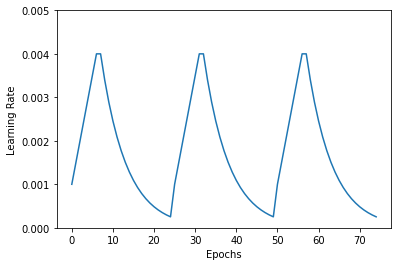

In [ ]:
learning_rate_test = []
for epoch in range(epochs):
  learning_rate_test.append( cyclical_adv_lrscheduler25(epoch) )
plt.figure()
plt.ylabel("Learning Rate")
plt.xlabel("Epochs")
plt.ylim([0.0000,0.005])
plt.plot(learning_rate_test)

In [ ]:
def work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=False):
  monitor='val_loss'
  if (show_model):
    input_shape = (target_size_x, target_size_y, 3)
  else:
    input_shape = (None, None, 3)
  for kType in [-1, cai.layers.D6v3_12ch(), cai.layers.D6v3_16ch(), cai.layers.D6v3_32ch()]:
      basefilename = '/content/drive/MyDrive/output/JP30M01-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      if kType == -1:
        model = cai.efficientnet.EfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes)
      else:
        model = cai.efficientnet.kEfficientNetB0(
          include_top=True,
          input_shape=input_shape,
          classes=num_classes,
          # skip_stride_cnt=0,
          kType=kType)
        
      optimizer = keras.optimizers.RMSprop()
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model):
        model.summary(line_length=180)
        print('model flops:',get_flops(model))

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed
            )
            validation_flow = valid_datagen.flow(
                x_val, y_val,
                batch_size=batch_size,
                shuffle=False,
                seed=seed
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=False,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        cai.datasets.test_flips_on_saved_model(x_test, y_test, best_result_file_name, has_flip_x=True, has_flip_y=True, has_bw=True, center_crop=0.15)
      print('Finished: '+basefilename)

# Show Models

In [ ]:
work_on_keffnet(show_model=True, run_fit=False, test_results=False)

Running: /content/drive/MyDrive/output/JP30M01--1
Model: "efficientnet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 224, 224, 3)]                   0                    []                                                          
                                                                                                                                                                                    
 stem_conv_pad (ZeroPadding2D)                             (None, 225, 225, 3)                     0                    ['input_1[0][0]']                                           
                    

# Fitting

Running: /content/drive/MyDrive/output/JP30M01--1
Epoch 1/75
345/345 [==============================] - ETA: 0s - loss: 1.1982 - accuracy: 0.5661
Epoch 00001: val_loss improved from inf to 1.00319, saving model to /content/drive/MyDrive/output/JP30M01--1-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


345/345 [==============================] - 133s 346ms/step - loss: 1.1982 - accuracy: 0.5661 - val_loss: 1.0032 - val_accuracy: 0.5330 - lr: 0.0010
Epoch 2/75
345/345 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8534
Epoch 00002: val_loss improved from 1.00319 to 0.22925, saving model to /content/drive/MyDrive/output/JP30M01--1-best_result.hdf5
345/345 [==============================] - 117s 333ms/step - loss: 0.3833 - accuracy: 0.8534 - val_loss: 0.2293 - val_accuracy: 0.9362 - lr: 0.0015
Epoch 3/75
345/345 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9063
Epoch 00003: val_loss did not improve from 0.22925
345/345 [==============================] - 114s 325ms/step - loss: 0.2791 - accuracy: 0.9063 - val_loss: 1.3497 - val_accuracy: 0.6622 - lr: 0.0020
Epoch 4/75
345/345 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.9053
Epoch 00004: val_loss improved from 0.22925 to 0.17601, saving model to /content/drive/

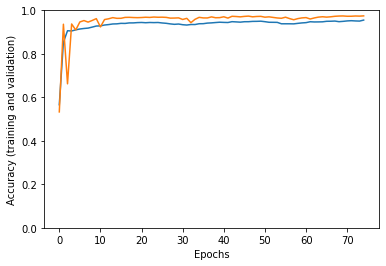

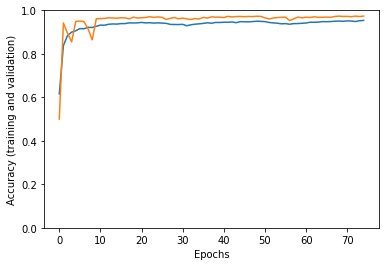

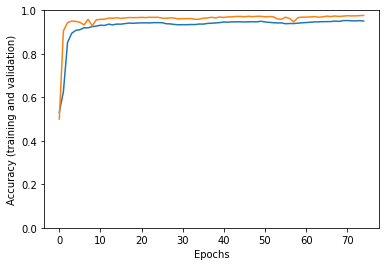

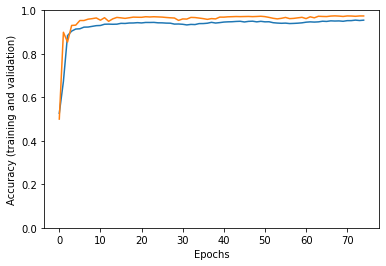

In [27]:
work_on_keffnet(show_model=False, run_fit=True, test_results=True)

# Test Results

In [28]:
work_on_keffnet(show_model=False, run_fit=False, test_results=True)

Running: /content/drive/MyDrive/output/JP30M01--1
Best Model Results: /content/drive/MyDrive/output/JP30M01--1-best_result.hdf5
44/44 [==============================] - 4s 59ms/step - loss: 0.0806 - accuracy: 0.9739
loss 0.08058969676494598
acc 0.9738751649856567
Finished: /content/drive/MyDrive/output/JP30M01--1
Running: /content/drive/MyDrive/output/JP30M01-42
Best Model Results: /content/drive/MyDrive/output/JP30M01-42-best_result.hdf5
44/44 [==============================] - 6s 74ms/step - loss: 0.0777 - accuracy: 0.9731
loss 0.0777270570397377
acc 0.9731494784355164
Finished: /content/drive/MyDrive/output/JP30M01-42
Running: /content/drive/MyDrive/output/JP30M01-32
Best Model Results: /content/drive/MyDrive/output/JP30M01-32-best_result.hdf5
44/44 [==============================] - 6s 68ms/step - loss: 0.0719 - accuracy: 0.9761
loss 0.07188543677330017
acc 0.9760522246360779
Finished: /content/drive/MyDrive/output/JP30M01-32
Running: /content/drive/MyDrive/output/JP30M01-33
Best M

In [29]:
work_on_keffnet(show_model=False, run_fit=False, test_results=False, calc_f1=True)

Running: /content/drive/MyDrive/output/JP30M01--1
Test Original
              precision    recall  f1-score   support

           0     0.9794    0.9681    0.9737      1378
           1     0.9684    0.9797    0.9740      1378

    accuracy                         0.9739      2756
   macro avg     0.9739    0.9739    0.9739      2756
weighted avg     0.9739    0.9739    0.9739      2756

Test Flip X
              precision    recall  f1-score   support

           0     0.9780    0.9688    0.9734      1378
           1     0.9691    0.9782    0.9736      1378

    accuracy                         0.9735      2756
   macro avg     0.9736    0.9735    0.9735      2756
weighted avg     0.9736    0.9735    0.9735      2756

Test Original + Flip X
              precision    recall  f1-score   support

           0     0.9809    0.9688    0.9748      1378
           1     0.9692    0.9811    0.9751      1378

    accuracy                         0.9750      2756
   macro avg     0.9750    0.